Klasyfikacja uporządkowanych danych za pomocą warstw przetwarzania wstępnego

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

In [39]:
#ładowanie zbioru danych petfinder
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip',dataset_url,extract=True,cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [40]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [41]:
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4,0,1)
dataframe = dataframe.drop(columns=['AdoptionSpeed','Description'])

In [42]:
train,val,test = np.split(dataframe.sample(frac=1),[int(0.8*len(dataframe)),int(0.9*len(dataframe))])

In [43]:
print(len(train),'training examples')
print(len(val),'validation examples')
print(len(test),'test examples')

9229 training examples
1154 validation examples
1154 test examples


In [44]:
#utworzenie potoku wejściowego
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key:value[:,tf.newaxis] for key,value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [45]:
batch_size = 5
train_ds = df_to_dataset(train,batch_size = batch_size)

<ipython-input-44-a989639dc007>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key:value[:,tf.newaxis] for key,value in dataframe.items()}


In [46]:
print(train_ds)

<_PrefetchDataset element_spec=({'Type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Age': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'Breed1': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Color1': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Color2': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'MaturitySize': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'FurLength': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Vaccinated': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Sterilized': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Health': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Fee': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'PhotoAmt': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'target': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, TensorSpec(shape=(Non

In [47]:
[(train_features,label_batch)] = train_ds.take(1)
print('każdy przypadek:',list(train_features.keys()))
print('Batch -> ages:',train_features['Age'])
print('Batch dla celów:',label_batch)

każdy przypadek: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
Batch -> ages: tf.Tensor(
[[ 2]
 [10]
 [ 8]
 [ 5]
 [ 3]], shape=(5, 1), dtype=int64)
Batch dla celów: tf.Tensor([0 0 1 1 1], shape=(5,), dtype=int64)


In [48]:
#ZAstosowanie warstwy przetwarzania wstępnego
#Warstwy przetwarzania wstępnego Keras dają możliwość tworzenia natywnych potoków danycb wejściowych Keras.
#Postawowe 4 warstwy przetwarzania wstępnego:
#Normalization
#categoryEncoding
#StringLookup
#IntegerLookup

In [49]:
#funkcja która zwraca warstwę, która stosuje normalizację funkcji pod kątem wartości numerycznych
def get_normalization_layer(name,dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x,y:x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [50]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt',train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.78625864],
       [-0.5152206 ],
       [ 0.46088883],
       [ 0.46088883],
       [ 0.78625864]], dtype=float32)>

In [51]:
#kolumny kategorialne
def get_category_encoding_layer(name,dataset,dtype,max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x,y:x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    return lambda feature:encoder(index(feature))

In [52]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(
    name='Type',
    dataset=train_ds,
    dtype='string'
)
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [53]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(
    name='Age',
    dataset=train_ds,
    dtype='int64',
    max_tokens=5
)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

In [54]:
#Przetwarzanie funkcji w celu przygotowania modelu do treningu
batch_size = 256
train_ds = df_to_dataset(train,batch_size=batch_size)
val_ds = df_to_dataset(val,shuffle=False,batch_size=batch_size)
test_ds = df_to_dataset(test,shuffle=False,batch_size=batch_size)

<ipython-input-44-a989639dc007>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key:value[:,tf.newaxis] for key,value in dataframe.items()}
<ipython-input-44-a989639dc007>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key:value[:,tf.newaxis] for key,value in dataframe.items()}
<ipython-input-44-a989639dc007>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key:value[:,tf.newaxis] for key,value in dataframe.items()}


In [55]:
all_inputs = []
encoded_features = []

for header in ['PhotoAmt','Fee']:
    numeric_col = tf.keras.Input(shape=(1,),name=header)
    normalization_layer = get_normalization_layer(header,train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [56]:
print(numeric_col)
print(encoded_features)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='Fee'), name='Fee', description="created by layer 'Fee'")
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>]


In [57]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [58]:
categorical_cols = ['Type','Color1','Color2','Gender','MaturitySize','FurLength','Vaccinated','Sterilized','Health','Breed1']
for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,),name=header,dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [59]:
print(all_inputs)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PhotoAmt')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>, <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Age')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color1')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color2')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Gender')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MaturitySize')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'FurLength')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Vaccinated')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sterilized')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Health')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Breed1')>]


In [60]:
#Tworzenie, kompilacja i trening modelu
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32,activation='relu')(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs,output)

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

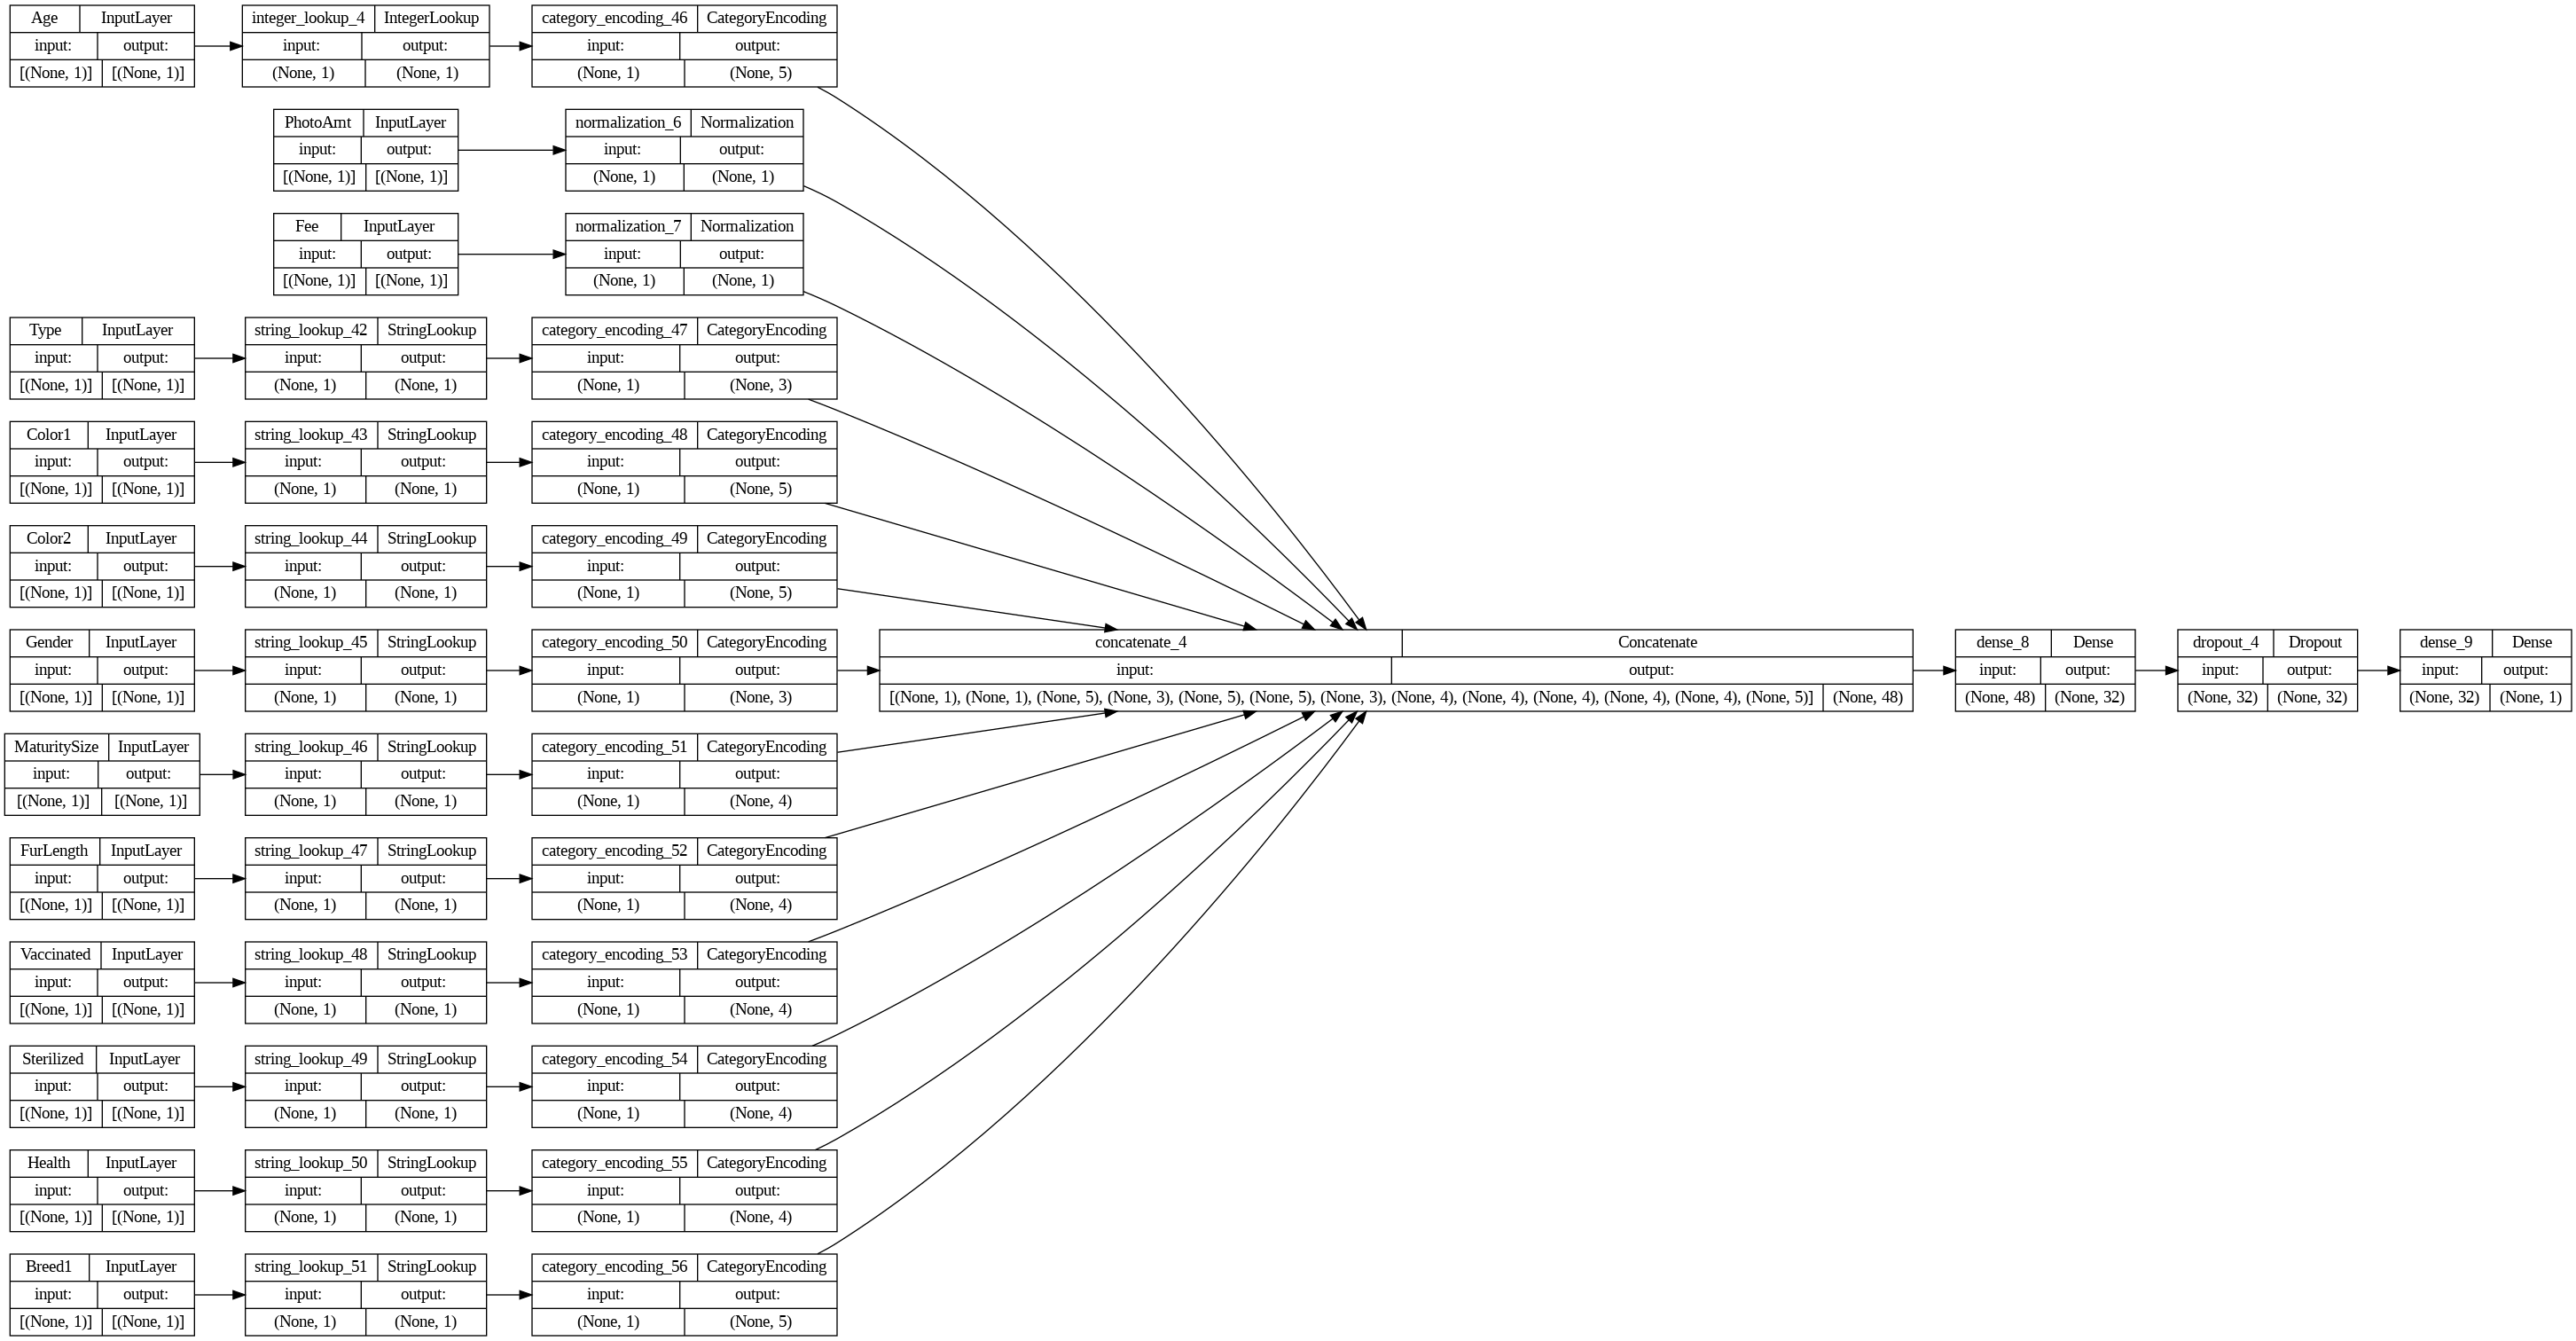

In [62]:
tf.keras.utils.plot_model(model,show_shapes=True,rankdir="LR")

In [65]:
model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
37/37 [==============================] - 3s 19ms/step - loss: 0.6772 - accuracy: 0.4423 - val_loss: 0.5695 - val_accuracy: 0.6612
Epoch 2/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5923 - accuracy: 0.6364 - val_loss: 0.5367 - val_accuracy: 0.7444
Epoch 3/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5673 - accuracy: 0.6748 - val_loss: 0.5186 - val_accuracy: 0.7539
Epoch 4/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5565 - accuracy: 0.6943 - val_loss: 0.5071 - val_accuracy: 0.7530
Epoch 5/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5477 - accuracy: 0.6954 - val_loss: 0.5004 - val_accuracy: 0.7556
Epoch 6/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5418 - accuracy: 0.7084 - val_loss: 0.4958 - val_accuracy: 0.7496
Epoch 7/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5357 - accuracy: 0.7125 - val_loss: 0.4925 - val_accuracy: 0.7522
Epoch 8/10
37/37 [=

In [66]:
loss,accuracy = model.evaluate(test_ds)
print(f"dopasowanie: {accuracy}")

5/5 [==============================] - 0s 5ms/step - loss: 0.5266 - accuracy: 0.7522
dopasowanie: 0.7521663904190063
